# Experiments with the exponential jumps algorithm

In [1]:
def jump(stream):
    "Weighted-reservoir sampling by jumping"
    R = None
    T = np.inf
    J = 0.0
    for i, w in enumerate(stream):
        J -= w
        if J <= 0:
            # Sample the key for item i, given that it is smaller than the current threshold
            T = Exponential.sample_truncated(w, 0, T)
            # i enters the reservoir
            R = i
            # sample the waiting time (size of the jump)
            J = Exponential.sample(T)
    return R

In [2]:
def walk(stream):
    "Weighted-reservoir sampling by walking"
    R = None
    T = np.inf
    J = 0.0
    for i, w in enumerate(stream):
        X = Exponential.sample(w)
        if X < T:
            R = i   # i enters the reservoir
            T = X   # threshold to enter the reservoir
    return R

In [3]:
import numpy as np, pylab as pl

def base(w):
    "Baseline algorithm for sampling from weights w"
    c = np.cumsum(w)
    u = np.random.uniform()
    return c.searchsorted(u * c[-1])

def empirical(gen, s, n, reps):
    "Compute empirical categorical distribution"
    q = np.zeros(n)
    for _ in range(reps):
        q[gen(s)] += 1
    q /= reps
    return q

def error(p, q, reps):
    "Compute total variation between two (possibly unnormalized) distributions `p` and `q`."
    assert p.shape == q.shape
    p = p / p.sum()
    q = q / q.sum()
    return 0.5 * np.abs(p-q).sum()  # total variation

class Exponential:
    
    @staticmethod
    def pdf(w, x):
        return w * np.exp(-x * w)
    
    @staticmethod
    def cdf(w, x):
        return 1 - np.exp(-x * w)
        
    @staticmethod
    def ppf(w, u):
        return -np.log1p(-u) / w

    @classmethod
    def sample(cls, w, u=None):
        "Generate a random variate."
        if u is None: u = np.random.uniform()
        return cls.ppf(w, u)

    @classmethod
    def sample_truncated(cls, w, a, b, u=None):
        "Generate a random variate such that `a <= X <= b`"
        assert a <= b
        if u is None: u = np.random.uniform()
        return cls.ppf(w, cls.cdf(w, a) + u * (cls.cdf(w, b) - cls.cdf(w, a)))

### Does it work?

Generate some test data

In [4]:
n = 20
w = np.random.uniform(0, 10, size=n)

In [5]:
reps = 100000
print('base error:', error(w, empirical(base, w, n, reps), reps))
print('walk error:', error(w, empirical(walk, w, n, reps), reps))
print('jump error:', error(w, empirical(jump, w, n, reps), reps))

base error: 0.005302418883592938
walk error: 0.005337774053666295
jump error: 0.005126327265828854


### Is it faster?

In [6]:
from arsenal.timer import timers
jobs = []
methods = {'walk': walk, 'jump': jump} #, 'base': base}
for i in range(20):
    n = 2 ** i
    for rep in range(3):
        w = np.random.uniform(0, 10, size=n)
        for name, method in methods.items():
            jobs.append([name, n, rep, method, w])
np.random.shuffle(jobs)  # shuffle jobs to avoid accidental correlations
T = timers()
for [name, n, rep, method, w] in jobs:
    with T[name](n=n):
        method(w)

In [7]:
T.compare()

jump is 4.2050x faster than walk (median: walk: 0.00163066 jump: 0.000387788)


**Where is the speed-up coming from?** Both algorithms are asymptotically linear time to sample.  However, the constant factors associated with the `jump` algorithm are smaller because it samples substantially fewer random variates.

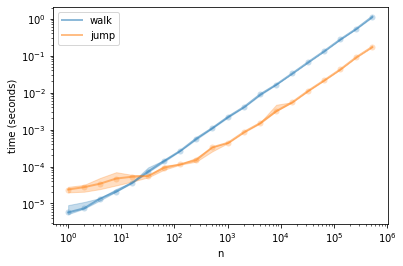

In [8]:
ax = T.plot_feature('n')
ax.set_xscale('log'); ax.set_yscale('log')